# SL-Ensemble in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinPlot import *
from utils.BasinInit import *

### Perturbing initial conditions

In [6]:
from utils.BasinParameters import *

In [7]:
sample_args

{'g': 9.81, 'f': 0.0012}

In [8]:
L = 10

In [9]:
lvl_grid_args = initGridSpecs(L)

args = {
    "nx": lvl_grid_args["nx"],
    "ny": lvl_grid_args["ny"],
    "dx": lvl_grid_args["dx"],
    "dy": lvl_grid_args["dy"],
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

In [10]:
data_args = make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist)


### Ensemble

In [11]:
from utils.BasinSL import *

In [12]:
Ne = 25

In [13]:
SL_ensemble = initSLensemble(Ne, args, data_args, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

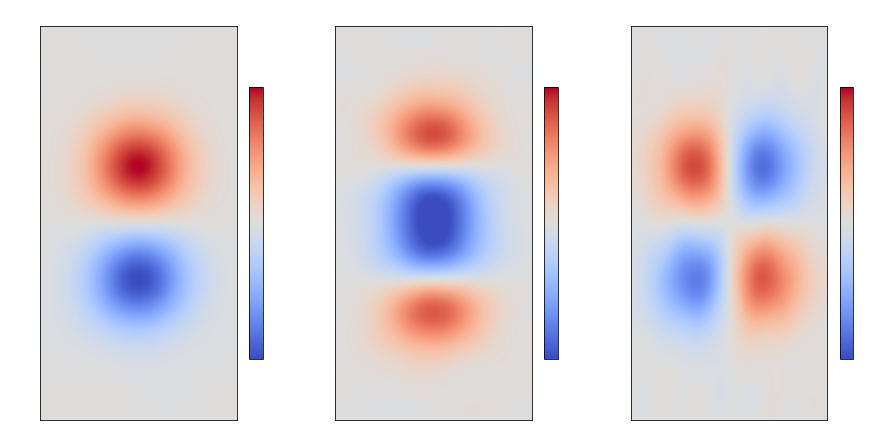

In [14]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3, huv_vlim=80)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

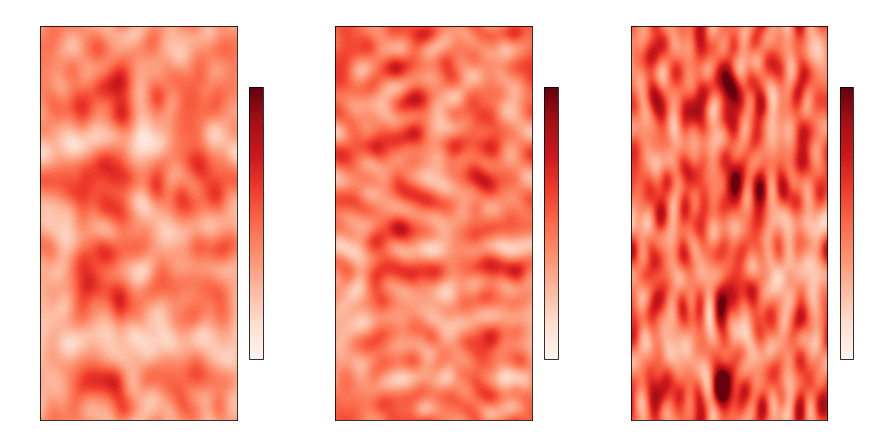

In [15]:
imshow3var(SLestimate(SL_ensemble, np.var), eta_vlim=0.015, huv_vlim=50)

### Truth

In [16]:
if init_model_error_basis_args:
    init_mekl = ModelErrorKL.ModelErrorKL(**args, **init_model_error_basis_args)

if sim_model_error_basis_args:
    sim_mekl = ModelErrorKL.ModelErrorKL(**args, **sim_model_error_basis_args)

sim_args = {
    "gpu_ctx" : args["gpu_ctx"],
    "nx" : args["nx"],
    "ny" : args["ny"],
    "dx" : args["dx"],
    "dy" : args["dy"],
    "f"  : sample_args["f"],
    "g"  : sample_args["g"],
    "r"  : 0,
    "dt" : 0,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
    "eta0" : data_args["eta"],
    "hu0"  : data_args["hu"],
    "hv0"  : data_args["hv"],
    "H"    : data_args["Hi"],
}


truth = CDKLM16.CDKLM16(**sim_args) 
if init_model_error_basis_args:
    init_mekl.perturbSim(truth)
if sim_model_error_basis_args:
    truth.model_error = sim_mekl
    truth.model_time_step = 60.0


### Rank histograms

In [17]:
freq = 50
Hxs = np.arange( 512, 1024, freq)
Hys = np.arange(1024, 2048, 2*freq)

In [18]:
N_ranks = 0

In [19]:
eta = data_args["eta"]
hu  = data_args["hu"]
hv  = data_args["hv"]

SL_ranks = np.zeros((len(Hxs)*N_ranks,3))
true_diag = np.zeros((N_ranks, 3, 1024))

for n in range(N_ranks):
    print(n)
    # new truth
    truth.upload(eta, hu, hv)
    init_mekl.perturbSim(truth)

    # ranks
    true_eta, true_hu, true_hv = truth.download()
    SL_state = SLdownload(SL_ensemble)
    ranks = np.zeros((len(Hxs),3))
    for h in range(len(Hxs)):
        Hx, Hy = Hxs[h], Hys[h]
        true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) 
        ranks[h] = np.sum( SL_state[:, Hy, Hx, :] < true_values[:,np.newaxis] , axis=1)/SL_state.shape[-1]     
    SL_ranks[n*len(Hxs):(n+1)*len(Hxs)] = ranks

    # # saving true diagonal
    true_diag[n] = [np.diag(v[::2,::1]) for v in truth.download(interior_domain_only=True)]

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


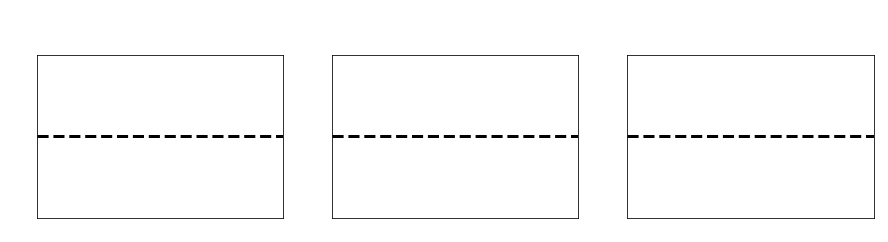

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ML ranks",y=1.1)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

bins_size= 1/25
bins = np.arange(0,1+1e-9,bins_size)

for i in range(3):
    hist = np.histogram(SL_ranks[:,i], bins=bins)
    axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0]/len(SL_ranks)/bins_size, width=bins_size, color="C0")
    
    # axs[i].set_ylim((0,1.5))
    axs[i].set_xlim((0,1.0))

    axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

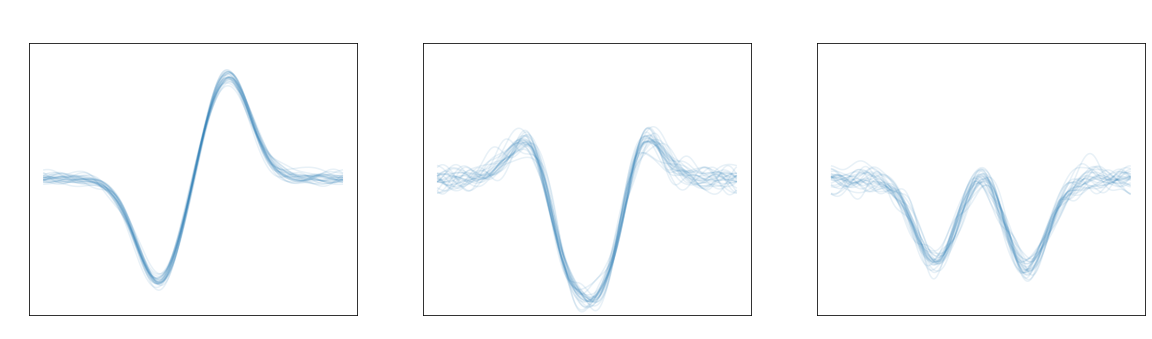

In [21]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Cut along the diagonal")

axs[2].set_ylabel("Ne = "+str(Ne))

SL_state = SLdownload(SL_ensemble)
# eta hu hv
for v in range(3):
    if v == 0:
        axs[v].set_ylim((-3,3))
    else:
        axs[v].set_ylim((-100,100))

    # ensemble member
    for e in range(Ne):
        axs[v].plot( np.diag(SL_state[v,::2,::1,e]), alpha=0.1, c="C0", zorder=1)

    if true_diag.size != 0:
        for diag_loc in range(32,1024,64):
            loc_truthes = np.moveaxis(true_diag,0,-1)[v,diag_loc,:]
            low, mean, up = np.quantile(loc_truthes, 0.1), np.mean(loc_truthes),np.quantile(loc_truthes,0.9)
            axs[v].scatter(diag_loc, mean, c="C1", marker="_", s=200, zorder=3)
            axs[v].vlines(x=diag_loc, ymin=low, ymax=up, colors="C1", lw=2, zorder=2)
    

### RMSE

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

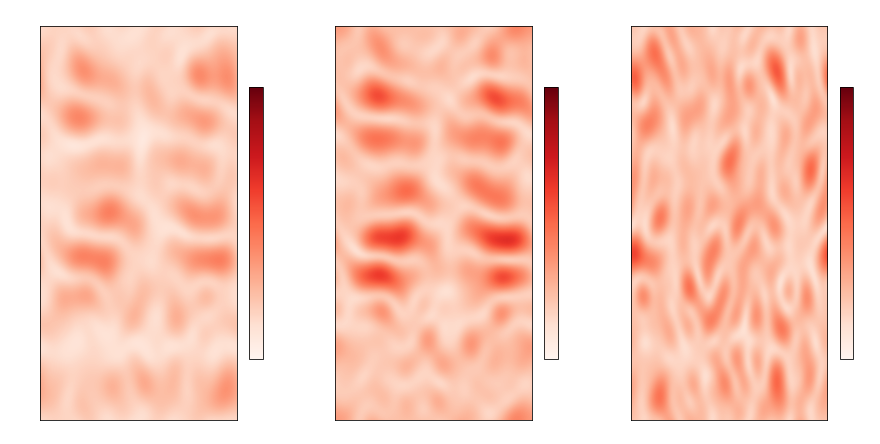

In [22]:
imshow3var( np.sqrt( 1/Ne*np.sum((SLdownload(SL_ensemble) - np.array(truth.download(interior_domain_only=True))[:,:,:,np.newaxis])**2, axis=-1) ), eta_vlim=0.5, huv_vlim=25) 

## Data Assimilation

In [23]:
Hx, Hy = 500, 1000

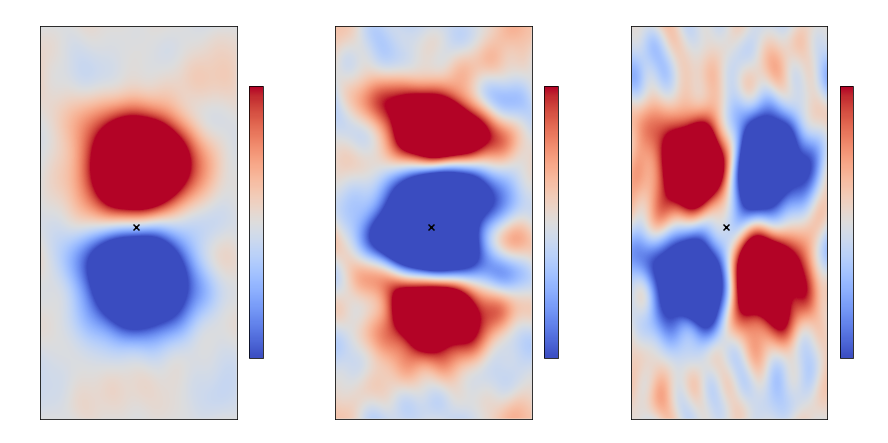

In [24]:
fig, axs = imshowSim(truth, eta_vlim=3, huv_vlim=100)

for i in range(3):
    axs[i].scatter(Hx, Hy, marker="x", c="black")

In [25]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

print([true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]])
print(obs)

[-0.22745867, -89.18897, -3.5948281]
[ -0.29256447 -89.83569233  -4.73392932]


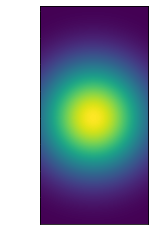

In [26]:
r = 5e4
localisation_weights = GCweights(SL_ensemble, Hx, Hy, r)
plt.imshow( localisation_weights, vmin=0 )

In [27]:
SL_K = SLEnKF(SL_ensemble, obs, Hx, Hy, R=R, obs_var=slice(1,3), localisation_weights=localisation_weights)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

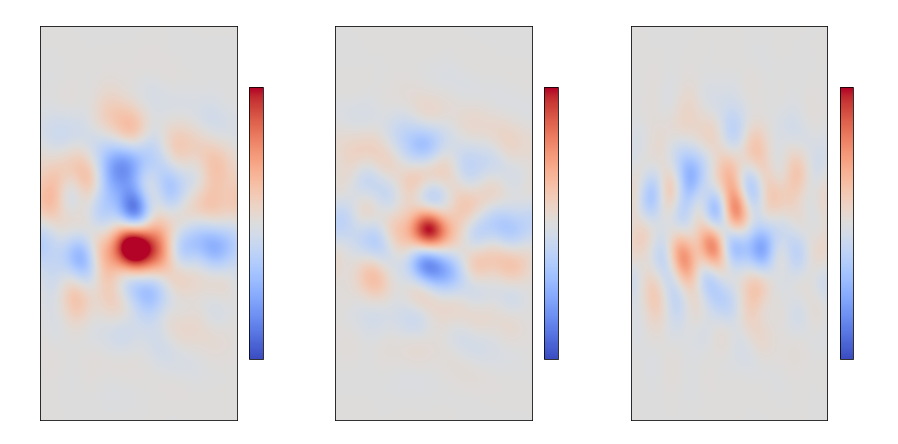

In [28]:
imshow3(SL_K[:,:,:,0], eta_vlim=1e-2, huv_vlim=1)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

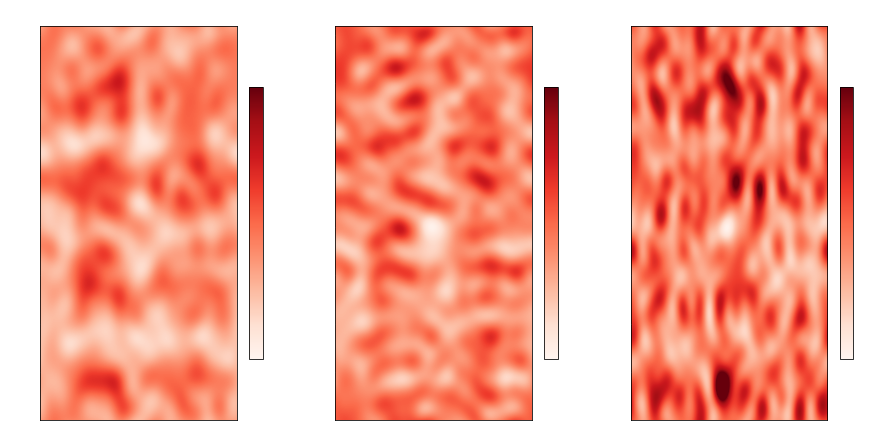

In [29]:
imshow3var(SLestimate(SL_ensemble, np.var), eta_vlim=0.015, huv_vlim=50, title="Var")

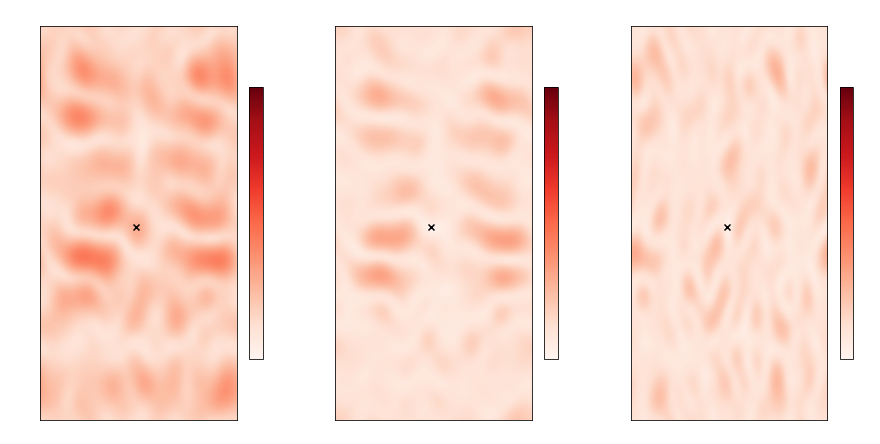

In [30]:
fig, axs = imshow3var( np.sqrt( 1/Ne*np.sum((SLdownload(SL_ensemble) - np.array(truth.download(interior_domain_only=True))[:,:,:,np.newaxis])**2, axis=-1) ), eta_vlim=0.5, huv_vlim=50, title="RMSE")
for i in range(3):
    axs[i].scatter(Hx, Hy, marker="x", c="black")

In [31]:
SLstepToObservation(SL_ensemble, 300)